In [63]:
from moku.instruments import MultiInstrument, DigitalFilterBox, FrequencyResponseAnalyzer
import control as ct
import altair as alt
import pandas as pd
import numpy as np

In [64]:
sample_freq = 39.06e6

In [65]:
#See the moku user manual for 
def second_order_section(s,b0,b1,b2,a1,a2):
    return ct.tf([s*b2,s*b1,s*b0],[a2,a1,1],1/(sample_freq))

In [66]:
# The following example array produces an 8th order Direct-form 1
# Chebyshev type 2 IIR filter with a normalized stopband frequency
# of 0.2 pi rad/sample and a stopband attenuation of 40 dB.

filter_coefficients = [
    [1.0000000000, 1.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000],
    [1.0000000000, 1.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000],
    [1.0000000000, 1.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000],
    [1.0000000000, 1.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000]]

In [67]:
sys = ct.tf([1],[1],1/(sample_freq))

for coeff in filter_coefficients:
    stage = second_order_section(*coeff)
    sys = ct.series(sys,stage)

In [68]:
# Configure IIR filter 1 of the DFB
dfb= DigitalFilterBox('192.168.50.57', force_connect=True, platform_id=4) #192.168.50.97 is the IP for Moku Pro 3

dfb.set_custom_filter(1, "39.06MHz", coefficients=filter_coefficients) #note that this should match sample_freq

dfb.set_input_gain(1,gain = 0)
dfb.set_output_gain(1,gain = 0)
dfb.set_frontend(1, "DC", "50Ohm", "0dB")

dfb.enable_output(1,True,True)

{'gain_range': '0dB', 'output': True, 'signal': True}

In [69]:
#configure the frequency sweep
fra = FrequencyResponseAnalyzer('192.168.50.97', force_connect=True, platform_id=4) #192.168.50.97 is the IP for Moku Pro 1
fra.set_sweep(start_frequency=10, stop_frequency=10e6, num_points=256,
                averaging_time=1e-3, averaging_cycles=10, settling_cycles=10,
                settling_time=1e-3)
fra.set_output(1, 0.5)

{'amplitude': 0.5, 'offset': 0.0}

In [70]:
delay = fra.start_sweep() 
print(delay)
data = fra.get_data(wait_complete = True)

{'estimated_sweep_time': 38.14498770181657}


In [71]:
fra.relinquish_ownership()
dfb.relinquish_ownership()

In [72]:
df_measured = pd.DataFrame(data = data['ch1'])

df_measured['label'] = 'measured'

df_measured['magnitude'] = 10**(df_measured['magnitude']/20) #convert to magnitude

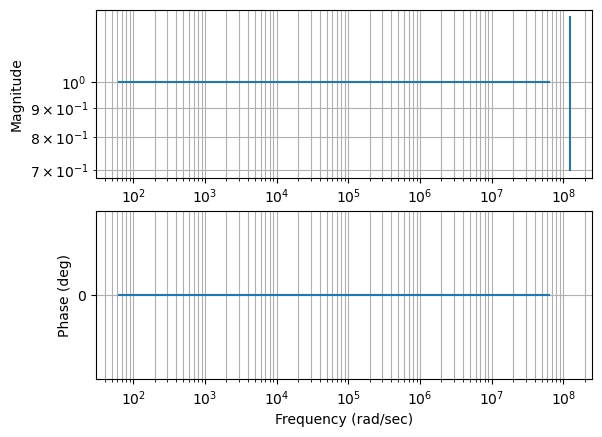

In [73]:
omega = df_measured['frequency'].to_numpy()*2*np.pi #convert the sample frequencies to rad/sec
mag,phase,omega = ct.bode_plot(sys,omega=omega)

In [74]:
df_model = pd.DataFrame().reindex(columns=df_measured.columns) #create another dataframe with the same columns
df_model['frequency'] = df_measured['frequency']
df_model['magnitude'] = mag
df_model['phase'] = (360*phase/(2*np.pi)+180)%360 -180 #convert to degrees and wrap phase
df_model['label'] = 'model'

In [75]:
df = pd.concat([df_model,df_measured])

In [76]:
magnitudechart = alt.Chart(df).mark_line(clip=True).encode(
    x=alt.X('frequency:Q').scale(type="log"),
    y=alt.Y('magnitude:Q').scale(type="log",domain=(0.9, 1.03)),
    color='label:N',
).properties(
    width=400,
    height=200
)

phasechart = alt.Chart(df).mark_line().encode(
    x=alt.X('frequency:Q').scale(type="log"),
    y=alt.Y('phase:Q'),
    color='label:N',
).properties(
    width=400,
    height=100
)

alt.vconcat(magnitudechart,phasechart)#.transform_filter(alt.FieldRangePredicate(field='freq', range=[8e6, 1e8]))

alt.VConcatChart(...)

In [77]:
data = df.loc[df['label'] == 'measured']
freq_diff = data['frequency'].diff()*2*np.pi #in rad/s
phase_diff = data['phase'].diff()*2*np.pi/360 #in radians
delay = pd.DataFrame(phase_diff/freq_diff,columns=['delay'])
data = pd.concat([data,delay],axis=1)
data


,frequency,magnitude,phase,label,delay
0,9.999992e+00,1.000812,-0.004613,measured,NaN
1,1.055672e+01,1.000834,-0.004505,measured,5.430866e-07
2,1.114445e+01,1.000853,-0.005355,measured,-4.017587e-06
3,1.176489e+01,1.000748,-0.004656,measured,3.125384e-06
4,1.241988e+01,1.000648,-0.005804,measured,-4.866945e-06
...,...,...,...,...,...
251,8.051603e+06,0.910197,74.392021,measured,1.129483e-06
252,8.499860e+06,0.905297,-123.688611,measured,-1.227475e-06
253,8.973073e+06,0.900051,26.817034,measured,8.834743e-07
254,9.472630e+06,0.894220,165.209543,measured,7.695278e-07


In [78]:
delaychart = alt.Chart(data).mark_line().encode(
    x=alt.X('frequency:Q').scale(type="log"),
    y=alt.Y('delay:Q'),
    color='label:N',
).properties(
    width=400,
    height=200
)
delaychart

alt.Chart(...)

In [79]:
data['delay'].median()*1e9 #in nanoseconds

-1215.1648856307634